<a href="https://colab.research.google.com/github/morioka/BayesFlow/blob/work_for_me/docs/source/tutorial_notebooks/Parameter_Estimation_Workflow_on_google_colab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## for running on google colab

In [1]:
!git clone https://github.com/morioka/BayesFlow.git

Cloning into 'BayesFlow'...
remote: Enumerating objects: 2137, done.
remote: Counting objects: 100% (463/463), done.
remote: Compressing objects: 100% (196/196), done.
remote: Total 2137 (delta 267), reused 455 (delta 264), pack-reused 1674
Receiving objects: 100% (2137/2137), 59.24 MiB | 31.98 MiB/s, done.
Resolving deltas: 100% (1210/1210), done.


In [2]:
!ls

BayesFlow  sample_data


In [3]:
!cd BayesFlow && git checkout work_for_me


Branch 'work_for_me' set up to track remote branch 'work_for_me' from 'origin'.
Switched to a new branch 'work_for_me'


In [4]:
!ls

BayesFlow  sample_data


In [5]:
#!pip install -U pip setuptools

In [6]:
!pip install -r BayesFlow/requirements.txt

     |████████████████████████████████| 4.1 MB 7.7 MB/s 
     |████████████████████████████████| 3.3 MB 47.7 MB/s 
     |████████████████████████████████| 38.1 MB 245 kB/s 
     |████████████████████████████████| 11.2 MB 56.0 MB/s 
     |████████████████████████████████| 131 kB 66.3 MB/s 
     |████████████████████████████████| 34.5 MB 1.2 MB/s 
     |████████████████████████████████| 462 kB 63.7 MB/s 
     |████████████████████████████████| 930 kB 53.9 MB/s 
     |████████████████████████████████| 130 kB 76.3 MB/s 
     |████████████████████████████████| 793 kB 64.1 MB/s 
     |████████████████████████████████| 428 kB 75.4 MB/s 
     |████████████████████████████████| 381 kB 71.2 MB/s 
  Attempting uninstall: tornado
    Found existing installation: tornado 5.1.1
    Uninstalling tornado-5.1.1:
      Successfully uninstalled tornado-5.1.1
  Attempting uninstall: prompt-toolkit
    Found existing installation: prompt-toolkit 1.0.18
    Uninstalling prompt-toolkit-1.0.18:
      Successf

In [1]:
#!pip install -e ./BayesFlow
# ... why? pandas-1.4.1 required. but not supported on colab.

In [2]:
#!pip install -U numpy scipy

In [3]:
import os, sys
sys.path.append(os.path.abspath(os.path.join('./BayesFlow')))

# Parameter Estimation Workflow  パラメータ推定のワークフロー

In [4]:
import os, sys
sys.path.append(os.path.abspath(os.path.join('../..')))

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

from numba import njit
import tensorflow as tf

In [5]:
from bayesflow.networks import InvertibleNetwork, InvariantNetwork
from bayesflow.amortizers import SingleModelAmortizer
from bayesflow.trainers import ParameterEstimationTrainer
from bayesflow.diagnostics import *
from bayesflow.models import GenerativeModel

In [6]:
%load_ext autoreload
%autoreload 2

## Simulator settings  シミュレータの設定

In [7]:
def prior(batch_size):
    """
    Samples from the prior 'batch_size' times.  事前分布から 'batch_size' 回だけサンプリングする
    ----------
    
    Arguments:
    batch_size : int -- the number of samples to draw from the prior
    ----------
    
    Output:
    theta : np.ndarray of shape (batch_size, theta_dim) -- the samples batch of parameters
    """
    
    # Prior ranges for the simulator 
    # v_c ~ U(-7.0, 7.0)
    # a_c ~ U(0.1, 4.0)
    # t0 ~ U(0.1, 3.0)
    p_samples = np.random.uniform(low=(0.1, 0.1, 0.1, 0.1, 0.1), 
                                  high=(7.0, 7.0, 4.0, 4.0, 3.0), size=(batch_size, 5))
    return p_samples.astype(np.float32)


@njit
def diffusion_trial(v, a, ndt, zr, dt, max_steps):
    """Simulates a trial from the diffusion model."""

    n_steps = 0.
    x = a * zr

    # Simulate a single DM path
    while (x > 0 and x < a and n_steps < max_steps):

        # DDM equation
        x += v*dt + np.sqrt(dt) * np.random.normal()

        # Increment step
        n_steps += 1.0

    rt = n_steps * dt
    return rt + ndt if x > 0. else -rt - ndt

@njit
def diffusion_condition(n_trials, v, a, ndt, zr=0.5, dt=0.005, max_steps=1e4):
    """Simulates a diffusion process over an entire condition."""
    
    x = np.empty(n_trials)
    for i in range(n_trials):
        x[i] = diffusion_trial(v, a, ndt, zr, dt, max_steps)
    return x


@njit
def diffusion_2_conds(params, n_trials, dt=0.005, max_steps=1e4):
    """
    Simulates a diffusion process for 2 conditions with 5 parameters (v1, v2, a1, a2, ndt).
    """
    
    n_trials_c1 = n_trials[0]
    n_trials_c2 = n_trials[1]
    
    v1, v2, a1, a2, ndt = params
    rt_c1 = diffusion_condition(n_trials_c1, v1, a1, ndt,  dt=dt, max_steps=max_steps)
    rt_c2 = diffusion_condition(n_trials_c2, v2, a2, ndt, dt=dt, max_steps=max_steps)
    rts = np.concatenate((rt_c1, rt_c2))
    return rts


def batch_simulator(prior_samples, n_obs, dt=0.005, s=1.0, max_iter=1e4):
    """
    Simulate multiple diffusion_model_datasets.
    """
    
    n_sim = prior_samples.shape[0]
    sim_data = np.empty((n_sim, n_obs), dtype=np.float32)
    
    n1 = n_obs//2
    n2 = n_obs - n1
    
    # Simulate diffusion data
    for i in range(n_sim):
        sim_data[i] = diffusion_2_conds(prior_samples[i], (n1, n2))
        
    # Create condition labels
    cond_arr = np.stack(n_sim * [np.concatenate((np.zeros(n1), np.ones(n2)))] )
    sim_data = np.stack((sim_data, cond_arr), axis=-1)
    
    return sim_data

## An example Bayesian workflow (with BayesFlow)  ベイズ的なワークフローの例(BayesFlowを用いて)

Towards a principled Bayesian workflow for cognitive modeling:

https://betanalpha.github.io/assets/case_studies/principled_bayesian_workflow.html

https://arxiv.org/abs/1904.12765

### Prior predictive checks

In [8]:
# Add stuff

### Train an amortized parameter estimation network  償却型パラメータ推定ネットワークの学習
Here, we use an invariant summary network and an invertible inference network with default settings.  ここでは不変サマリネットワークと可逆推論ネットワークをデフォルト設定で用いる。

We connect the networks through a *SingleModelAmortizer* instance. ネットワークは *SinglemodelAmortizer* インスタンスを通じて結合する。

In [9]:
summary_net = InvariantNetwork()
inference_net = InvertibleNetwork({'n_params': 5})
amortizer = SingleModelAmortizer(inference_net, summary_net)

2022-05-12 15:28:47.450241: W tensorflow/core/common_runtime/gpu/gpu_bfc_allocator.cc:39] Overriding allow_growth setting because the TF_FORCE_GPU_ALLOW_GROWTH environment variable is set. Original config value was 0.


We connect the prior and simulator through a *GenerativeModel* class which will take care of forward inference.  事前分布とシミュレータを *GeneraiveModel* クラスを介して結合する。これは前向き推論の面倒を見る。

In [10]:
generative_model = GenerativeModel(prior, batch_simulator)

In [11]:
trainer = ParameterEstimationTrainer(
    network=amortizer, 
    generative_model=generative_model,
)

### Offline training

#### Using pre-simulated data

In [12]:
# Pre-simulated data (could be loaded from somewhere else)
n_sim = 5000
n_obs = 100
true_params, x = generative_model(n_sim, n_obs)

In [13]:
%%time
losses = trainer.train_offline(epochs=1, batch_size=64, params=true_params, sim_data=x)

Converting 5000 simulations to a TensorFlow data set...


Training epoch 1:   0%|          | 0/79 [00:00<?, ?it/s]

CPU times: user 11.4 s, sys: 218 ms, total: 11.6 s
Wall time: 20.5 s


In [14]:
del true_params, x

#### Using internally simulated data

In [15]:
%%time
losses = trainer.simulate_and_train_offline(n_sim=1000, epochs=2, batch_size=32, n_obs=n_obs)

Simulating 1000 data sets upfront...
Converting 1000 simulations to a TensorFlow data set...


Training epoch 1:   0%|          | 0/32 [00:00<?, ?it/s]

Training epoch 2:   0%|          | 0/32 [00:00<?, ?it/s]

CPU times: user 9.17 s, sys: 141 ms, total: 9.31 s
Wall time: 11.1 s


### Online training

In [16]:
# Fixed n_obs

In [17]:
%%time
losses = trainer.train_online(epochs=2, iterations_per_epoch=100, batch_size=32, n_obs=n_obs)

Training epoch 1:   0%|          | 0/100 [00:00<?, ?it/s]

Training epoch 2:   0%|          | 0/100 [00:00<?, ?it/s]

CPU times: user 31.2 s, sys: 562 ms, total: 31.8 s
Wall time: 32.1 s


In [18]:
# Variable n_obs  可変の観測数 n_obs
def prior_N(n_min=60, n_max=300):
    """
    A prior or the number of observation (will be called internally at each backprop step).
    観測数 (高々1回であることはなさそう。観測を平均して用いる前提か)
    """
    
    return np.random.randint(n_min, n_max+1)

In [19]:
%%time
losses = trainer.train_online(epochs=2, iterations_per_epoch=100, batch_size=32, n_obs=prior_N)

Training epoch 1:   0%|          | 0/100 [00:00<?, ?it/s]

Training epoch 2:   0%|          | 0/100 [00:00<?, ?it/s]

CPU times: user 34.1 s, sys: 523 ms, total: 34.7 s
Wall time: 35.5 s


### Round-based training

In [20]:
%%time
losses = trainer.train_rounds(epochs=1, rounds=5, sim_per_round=200, batch_size=32, n_obs=n_obs)

Simulating initial 200 data sets...
Converting 200 simulations to a TensorFlow data set...


Training epoch 1:   0%|          | 0/7 [00:00<?, ?it/s]

Simulating new 200 data sets and appending to previous...
New total number of simulated data sets: 400
Converting 400 simulations to a TensorFlow data set...


Training epoch 1:   0%|          | 0/13 [00:00<?, ?it/s]

Simulating new 200 data sets and appending to previous...
New total number of simulated data sets: 600
Converting 600 simulations to a TensorFlow data set...


Training epoch 1:   0%|          | 0/19 [00:00<?, ?it/s]

Simulating new 200 data sets and appending to previous...
New total number of simulated data sets: 800
Converting 800 simulations to a TensorFlow data set...


Training epoch 1:   0%|          | 0/25 [00:00<?, ?it/s]

Simulating new 200 data sets and appending to previous...
New total number of simulated data sets: 1000
Converting 1000 simulations to a TensorFlow data set...


Training epoch 1:   0%|          | 0/32 [00:00<?, ?it/s]

CPU times: user 13.4 s, sys: 251 ms, total: 13.6 s
Wall time: 17.5 s


### Experience-replay training

In [21]:
%%time
losses = trainer.train_experience_replay(epochs=30,  # 3 -> 30
                                         batch_size=32, 
                                         iterations_per_epoch=100, 
                                         capacity=100,
                                         n_obs=prior_N)

Training epoch 1:   0%|          | 0/100 [00:00<?, ?it/s]

Training epoch 2:   0%|          | 0/100 [00:00<?, ?it/s]

Training epoch 3:   0%|          | 0/100 [00:00<?, ?it/s]

Training epoch 4:   0%|          | 0/100 [00:00<?, ?it/s]

Training epoch 5:   0%|          | 0/100 [00:00<?, ?it/s]

Training epoch 6:   0%|          | 0/100 [00:00<?, ?it/s]

Training epoch 7:   0%|          | 0/100 [00:00<?, ?it/s]

Training epoch 8:   0%|          | 0/100 [00:00<?, ?it/s]

Training epoch 9:   0%|          | 0/100 [00:00<?, ?it/s]

Training epoch 10:   0%|          | 0/100 [00:00<?, ?it/s]

Training epoch 11:   0%|          | 0/100 [00:00<?, ?it/s]

Training epoch 12:   0%|          | 0/100 [00:00<?, ?it/s]

Training epoch 13:   0%|          | 0/100 [00:00<?, ?it/s]

Training epoch 14:   0%|          | 0/100 [00:00<?, ?it/s]

Training epoch 15:   0%|          | 0/100 [00:00<?, ?it/s]

Training epoch 16:   0%|          | 0/100 [00:00<?, ?it/s]

Training epoch 17:   0%|          | 0/100 [00:00<?, ?it/s]

Training epoch 18:   0%|          | 0/100 [00:00<?, ?it/s]

Training epoch 19:   0%|          | 0/100 [00:00<?, ?it/s]

Training epoch 20:   0%|          | 0/100 [00:00<?, ?it/s]

Training epoch 21:   0%|          | 0/100 [00:00<?, ?it/s]

Training epoch 22:   0%|          | 0/100 [00:00<?, ?it/s]

Training epoch 23:   0%|          | 0/100 [00:00<?, ?it/s]

Training epoch 24:   0%|          | 0/100 [00:00<?, ?it/s]

Training epoch 25:   0%|          | 0/100 [00:00<?, ?it/s]

Training epoch 26:   0%|          | 0/100 [00:00<?, ?it/s]

Training epoch 27:   0%|          | 0/100 [00:00<?, ?it/s]

Training epoch 28:   0%|          | 0/100 [00:00<?, ?it/s]

Training epoch 29:   0%|          | 0/100 [00:00<?, ?it/s]

Training epoch 30:   0%|          | 0/100 [00:00<?, ?it/s]

CPU times: user 8min 27s, sys: 7.93 s, total: 8min 35s
Wall time: 8min 38s


## Custom networks

In [22]:
sum_meta = {
    'n_dense_s1': 2,
    'n_dense_s2': 2,
    'n_dense_s3': 2,
    'n_equiv':    2,
    'dense_s1_args': {'activation': 'relu', 'units': 64},
    'dense_s2_args': {'activation': 'relu', 'units': 64},
    'dense_s3_args': {'activation': 'relu', 'units': 64},
}

bf_meta = {
    'n_coupling_layers': 4,
    's_args': {
        'units': [64, 64, 64],
        'activation': 'elu',
        'initializer': 'glorot_uniform',
    },
    't_args': {
        'units': [64, 64, 64],
        'activation': 'elu',
        'initializer': 'glorot_uniform',
    },
    'n_params': 5,
    'alpha': 1.9,
    'permute': True
}

In [23]:
if False:
  summary_net = InvariantNetwork(sum_meta)
  inference_net = InvertibleNetwork(bf_meta)
  amortizer = SingleModelAmortizer(inference_net, summary_net)

## Compuational faithfulness 計算の忠実性
(Via simulation-based calibration シミュレーションベースのキャリブレーションを介して)

In [24]:
n_sbc = 5000
n_post_samples_sbc = 250
n_obs = 100
params_sbc = prior(n_sbc) # (5000, 5)
x_sbc = batch_simulator(params_sbc, n_obs)  # (5000, 100, 2)
#param_samples = np.concatenate([amortizer.sample(x, n_post_samples_sbc) 
#                                for x in tf.split(x_sbc, 10, axis=0)], axis=1)  # (500,2500, 5) shapeが params_sbcとミスマッチ
param_samples = np.concatenate([amortizer.sample(x, n_post_samples_sbc) 
                                for x in tf.split(x_sbc, 10, axis=0)], axis=0)   # (5000, 250, 5)

In [25]:
params_sbc.shape, x_sbc.shape, param_samples.shape # , amortizer.sample(np.split(x_sbc, 1, axis=0)[-1], 1000).shape
# amorizer.sampleが返すのは、ドキュメントの通りなら、(n_datasets, n_samples, n_params)でなく、(n_samples, n_datasets, n_params)のはず ...どちらかがおかしい。
# 元はドキュメントの通りでnotebookもその面影がある。しかし、現状は (n_datasets, n_samples, n_params)のほうだと考えるのが自然。

# In the document and original notebooks, amortizer.sample() returns ndarray(n_samples, n_datasets, n_params). But, it acuttually returns ndarray(n_datasets n_samples, n_params).

((5000, 5), (5000, 100, 2), (5000, 250, 5))

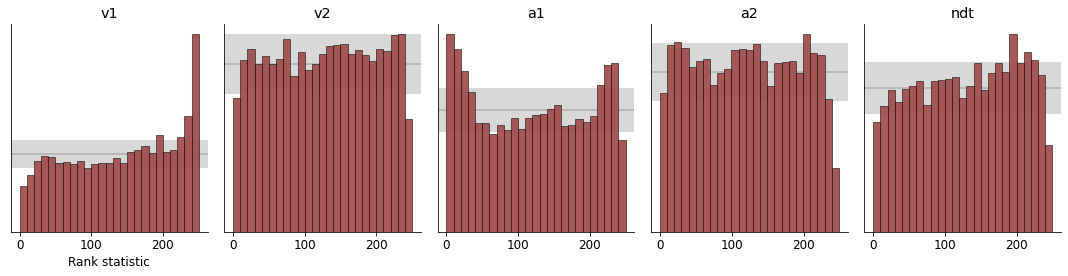

In [26]:
f = plot_sbc(param_samples, params_sbc, param_names=['v1', 'v2', 'a1', 'a2', 'ndt'], figsize=(15, 4))

## Model sensitivity/adequacy モデルの感度と妥当性



### Quick and dirty  簡易チェック

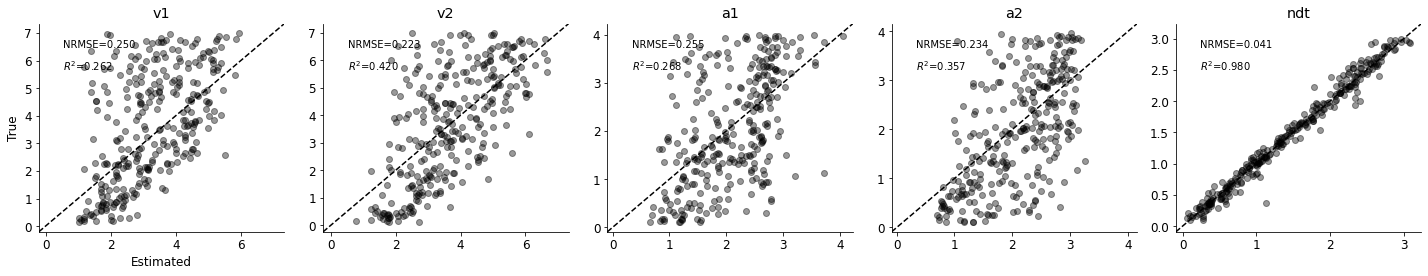

In [27]:
# Validate (quick and dirty)
true_params = prior(300)  # (300, 5)
#x = batch_simulator(true_params).astype(np.float32)
x = batch_simulator(true_params, 100).astype(np.float32)  # (300, 100, 2) (n_datasets, n_obs, n_dim)
param_samples = amortizer.sample(x, n_samples=1000)  # (300, 1000, 5) (n_datasets, n_samples, n_params)?
#param_means = param_samples.mean(axis=0)  # (1000, 5)
param_means = param_samples.mean(axis=1)  # (300, 5) (n_datasets, n_params)
true_vs_estimated(true_params, param_means, ['v1', 'v2', 'a1', 'a2','ndt']);

### A Bayesian eyechart  ベイズ的視力表(?)

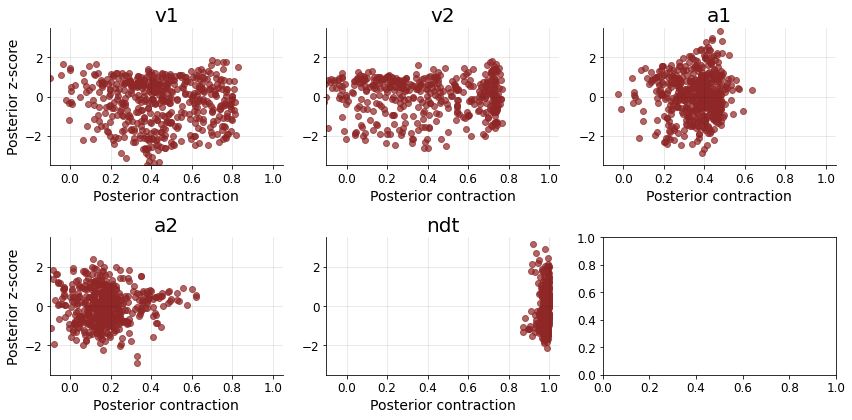

In [28]:
# Simulate シミュレーション
param_names = ['v1', 'v2', 'a1', 'a2','ndt']
n_sim_s = 500
n_samples_posterior = 1000
n_obs = 100
true_params = prior(n_sim_s)  # (500, 5)
#x = batch_simulator(true_params)
x = batch_simulator(true_params, n_obs)

# Sample from posterior
param_samples = amortizer.sample(x, n_samples_posterior)  # (500, 1000, 5)

### Posterior z-score  事後分布のzスコア
# Compute posterior means and stds  事後分布の平均と標準偏差を算出
#post_means = param_samples.mean(0) # (1000, 5)
#post_stds = param_samples.std(0)   # (1000, 5)
#post_vars = param_samples.var(0)   # (1000, 5)
post_means = param_samples.mean(1)  # (500, 5)
post_stds = param_samples.std(1)    # (500, 5)
post_vars = param_samples.var(1)    # (500, 5)

# Compute posterior z score  事後分布のzスコアを計算
post_z_score = (post_means - true_params) / post_stds

### Posterior contraction, i.e., 1 - post_var / prior_var  事後分布の収縮率
prior_a = (0.1, 0.1, 0.1, 0.1, 0.1) # lower bound of uniform prior  一様分布の下限
prior_b = (7.0, 7.0, 4.0, 4.0, 3.0) # upper bound of uniform prior  一様分布の上限

# Compute prior vars analytically  # 事前分布の分散を解析的に算出
prior_vars = np.array([(b-a)**2/12 for a,b in zip(prior_a, prior_b)])
post_cont = 1 - post_vars / prior_vars

# Plotting time  表示
f, axarr = plt.subplots(2, 3, figsize=(12, 6))
for i, (p, ax) in enumerate(zip(param_names, axarr.flat)):
    ax.scatter(post_cont[:, i], post_z_score[:, i], color='#8f2727', alpha=0.7)
    ax.set_title(p, fontsize=20)
    sns.despine(ax=ax)
    ax.set_xlim([-0.1, 1.05])
    ax.set_ylim([-3.5, 3.5])
    ax.grid(color='black', alpha=0.1)
    ax.set_xlabel('Posterior contraction', fontsize=14)
    if i == 0 or i == 3:
        ax.set_ylabel('Posterior z-score', fontsize=14)
f.tight_layout()

## Posterior postdictive/predictive checks